In [4]:
import numpy as np 
import pandas as pd 
from PIL import Image 
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications import ResNet50

In [5]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 8

TRAIN_POSITIVE_SIZE = 460
TRAIN_NEGATIVE_SIZE = 4684
VALIDATION_POSITIVE_SIZE = 58
VALIDATION_NEGATIVE_SIZE = 562
TEST_POSITIVE_SIZE = 58
TEST_NEGATIVE_SIZE = 610

IMG_DIR = '/content/drive/MyDrive/summer 2021/sra/research/data/'
TRAIN_DIR = '/content/drive/MyDrive/summer 2021/sra/research/data/train'
VAL_DIR = '/content/drive/MyDrive/summer 2021/sra/research/data/validation'
TEST_DIR = '/content/drive/MyDrive/summer 2021/sra/research/data/test'

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                              horizontal_flip = True,
                                              width_shift_range = 0.2,
                                              height_shift_range = 0.2
                                              )
            
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train_generator = data_generator_with_aug.flow_from_directory(
                                        directory=TRAIN_DIR,
                                        target_size=IMG_DIM,
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical'
                                        )

validation_generator = data_generator_no_aug.flow_from_directory(
                                        directory=VAL_DIR,
                                        target_size=IMG_DIM,batch_size=BATCH_SIZE,
                                        class_mode='categorical')

test_generator = data_generator_no_aug.flow_from_directory(
                                        directory=TEST_DIR,
                                        target_size=IMG_DIM,batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        )

print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

Found 5144 images belonging to 3 classes.
Found 620 images belonging to 3 classes.
Found 668 images belonging to 3 classes.
{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}
{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}
{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Model
import tensorflow.keras as keras

mobilenet_v2 = MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3),pooling='max')

output = mobilenet_v2.layers[-1].output
output = tf.keras.layers.Flatten()(output)
mobilenet_v2 = Model(mobilenet_v2.input, output)

res_name = []
for layer in mobilenet_v2.layers:
    res_name.append(layer.name)

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
res_name[-156:]

['input_1',
 'Conv1',
 'bn_Conv1',
 'Conv1_relu',
 'expanded_conv_depthwise',
 'expanded_conv_depthwise_BN',
 'expanded_conv_depthwise_relu',
 'expanded_conv_project',
 'expanded_conv_project_BN',
 'block_1_expand',
 'block_1_expand_BN',
 'block_1_expand_relu',
 'block_1_pad',
 'block_1_depthwise',
 'block_1_depthwise_BN',
 'block_1_depthwise_relu',
 'block_1_project',
 'block_1_project_BN',
 'block_2_expand',
 'block_2_expand_BN',
 'block_2_expand_relu',
 'block_2_depthwise',
 'block_2_depthwise_BN',
 'block_2_depthwise_relu',
 'block_2_project',
 'block_2_project_BN',
 'block_2_add',
 'block_3_expand',
 'block_3_expand_BN',
 'block_3_expand_relu',
 'block_3_pad',
 'block_3_depthwise',
 'block_3_depthwise_BN',
 'block_3_depthwise_relu',
 'block_3_project',
 'block_3_project_BN',
 'block_4_expand',
 'block_4_expand_BN',
 'block_4_expand_relu',
 'block_4_depthwise',
 'block_4_depthwise_BN',
 'block_4_depthwise_relu',
 'block_4_project',
 'block_4_project_BN',
 'block_4_add',
 'block_5_e

In [ ]:
set_trainable = False
for layer in mobilenet_v2.layers:
    if layer.name in res_name[-156:]:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
mobilenet_v2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout

num_classes = 3

model = Sequential()
model.add(mobilenet_v2)
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3075      
Total params: 4,622,403
Trainable params: 4,588,291
Non-trainable params: 34,112
_________________________________________

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8,
                                              restore_best_weights=False
                                              )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.2,
                                   patience=4,
                                   verbose=1,
                                   min_delta=5*1e-3,min_lr = 5*1e-7,
                                   )

In [ ]:
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics=['accuracy', tfa.metrics.F1Score(num_classes=num_classes)])

In [ ]:
model.fit(
          train_generator,     
          epochs = 12,
          callbacks=[early_stop,reduce_lr],
          validation_data = validation_generator
          )

Epoch 1/12
643/643 [==============================] - ETA: 0s - loss: 0.9309 - accuracy: 0.8002 - f1_score: 0.7227

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


643/643 [==============================] - 1734s 3s/step - loss: 0.9309 - accuracy: 0.8002 - f1_score: 0.7227 - val_loss: 1.3113 - val_accuracy: 0.6855 - val_f1_score: 0.3946
Epoch 2/12
643/643 [==============================] - 202s 314ms/step - loss: 0.3439 - accuracy: 0.8964 - f1_score: 0.8697 - val_loss: 0.4740 - val_accuracy: 0.8258 - val_f1_score: 0.7689
Epoch 3/12
643/643 [==============================] - 201s 313ms/step - loss: 0.2457 - accuracy: 0.9185 - f1_score: 0.9026 - val_loss: 0.8819 - val_accuracy: 0.7532 - val_f1_score: 0.6400
Epoch 4/12
643/643 [==============================] - 202s 314ms/step - loss: 0.2041 - accuracy: 0.9327 - f1_score: 0.9192 - val_loss: 0.7889 - val_accuracy: 0.7758 - val_f1_score: 0.6851
Epoch 5/12
643/643 [==============================] - 200s 311ms/step - loss: 0.1851 - accuracy: 0.9413 - f1_score: 0.9274 - val_loss: 0.2030 - val_accuracy: 0.9323 - val_f1_score: 0.9169
Epoch 6/12
643/643 [==============================] - 199s 309ms/step - l

In [ ]:
def get_diagnostic_plot(model,name):
    training_loss = model.history.history[name]
    test_loss = model.history.history[f'val_{name}']

    epoch_count = range(1, len(training_loss) + 1)

    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend([f'Training {name}', f'Val {name}'])
    plt.xlabel('Epoch')
    plt.ylabel(name)

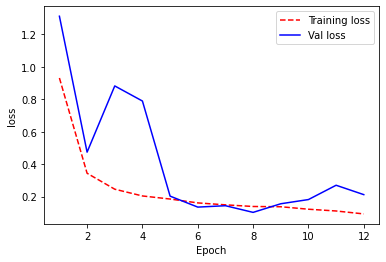

In [ ]:
get_diagnostic_plot(model,'loss')

In [ ]:
save_path = 'mobilenetv2/'
tf.keras.models.save_model(model,save_path)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: mobilenetv2/assets


In [ ]:
f1_score_history = model.history.history['f1_score']
f1_scores = [np.mean(item) for item in  f1_score_history]
f1_score_val_hist = model.history.history['val_f1_score']
f1_scores_val = [np.mean(item) for item in  f1_score_val_hist]

Text(0, 0.5, 'F1 Score')

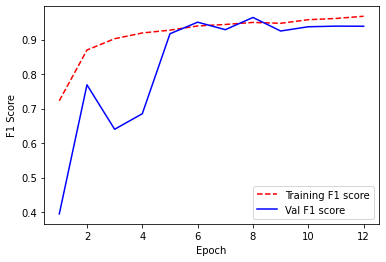

In [ ]:
training_loss = f1_scores
test_loss = f1_scores_val

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training F1 score', 'Val F1 score'])
plt.xlabel('Epoch')
plt.ylabel('F1 Score')

In [ ]:
model.evaluate(test_generator)

 1/84 [..............................] - ETA: 16s - loss: 0.1320 - accuracy: 0.8750 - f1_score: 0.8963

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


84/84 [==============================] - 188s 2s/step - loss: 0.1457 - accuracy: 0.9656 - f1_score: 0.9444


[0.14572712779045105,
 0.9655688405036926,
 array([0.91588783, 0.9341317 , 0.9832402 ], dtype=float32)]

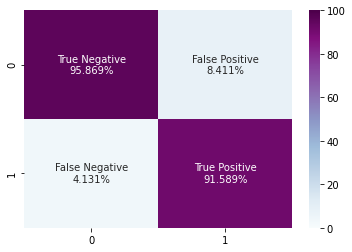

In [6]:
import seaborn as sns

f1_scores = np.array([0.91588783, 0.9341317 , 0.9832402 ])

tp = f1_scores[0] * TEST_POSITIVE_SIZE
tn = ((f1_scores[1] + f1_scores[2])/2) * TEST_NEGATIVE_SIZE
fp = (1-f1_scores[0]) * TEST_NEGATIVE_SIZE
fn = (((1-f1_scores[1]) + (1-f1_scores[2]))/2) * TEST_POSITIVE_SIZE

cf_matrix = np.array([[tn / TEST_NEGATIVE_SIZE * 100, fp / TEST_NEGATIVE_SIZE * 100],
                      [fn / TEST_POSITIVE_SIZE * 100, tp / TEST_POSITIVE_SIZE * 100]
                    ])

group_names = ['True Negative','False Positive','False Negative','True Positive']
percentages = [tn / TEST_NEGATIVE_SIZE, fp / TEST_NEGATIVE_SIZE, fn / TEST_POSITIVE_SIZE, tp / TEST_POSITIVE_SIZE]
group_percentages = ["{0:.3%}".format(value) for value in percentages]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, vmin = 0, vmax = 100, annot=labels, fmt='', cmap='BuPu')

In [7]:
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

Sensitivity: 0.9568387287329607
Specificity: 0.9193399293815374
